<a href="https://colab.research.google.com/github/mirab62807/DataScience/blob/main/project/apple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install econml

In [194]:
from econml.metalearners import XLearner
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

In [59]:
def abs_ate(effect_true, effect_pred):
    """
    Absolute error for the Average Treatment Effect (ATE)
    :param effect_true: true treatment effect value
    :param effect_pred: predicted treatment effect value
    :return: absolute error on ATE
    """
    # YOUR CODE HERE
    return np.abs(np.mean(effect_pred) - np.mean(effect_true))

def pehe(effect_true, effect_pred):
    """
    Precision in Estimating the Heterogeneous Treatment Effect (PEHE)
    :param effect_true: true treatment effect value
    :param effect_pred: predicted treatment effect value
    :return: PEHE
    """
    # YOUR CODE HERE
    return np.sqrt(np.mean((effect_true - effect_pred)**2))

In [60]:
ihdp = np.load('ihdp.npz')
ihdp.files

for f in ihdp.files:
  print(f'{f}: {ihdp[f].shape}')

x: (747, 25)
t: (747, 1)
yf: (747, 1)
ycf: (747, 1)
ite: (747, 1)


In [61]:
X = ihdp['x']
t = ihdp['t']
yf = ihdp['yf']
ycf = ihdp['ycf']
ite = ihdp['ite']

print(ite.shape)

(747, 1)


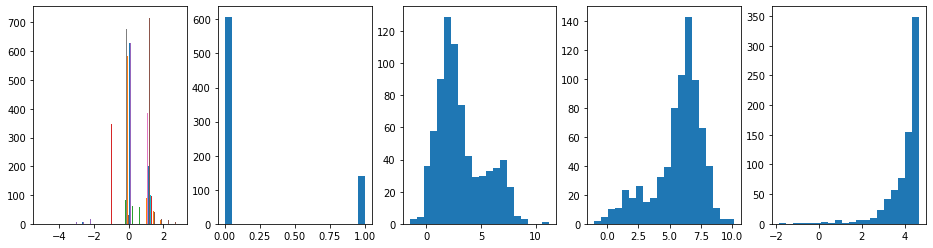

In [62]:
bins=20
fig, axs = plt.subplots(1, 5, figsize=(16, 4))
axs[0].hist(X, bins=bins)
axs[1].hist(t, bins=bins)
axs[2].hist(yf, bins=bins)
axs[3].hist(ycf, bins=bins)
axs[4].hist(ite, bins=bins)
plt.show()

In [63]:
np.mean(ite)

In [64]:
# limit = 100
# plt.scatter(X[t == 1][:limit], yf[t == 1][:limit], c = "r", label = "Treated")
# plt.scatter(X[t == 0][:limit], yf[t == 0][:limit], c = "g", label = "Control")
# plt.legend(ncol=2)

In [133]:
#Spliting the dataset

x_train, x_test, t_train, t_test, yf_train, yf_test, ycf_train, ycf_test, ite_train, ite_test = train_test_split(X, t, yf, ycf, ite, test_size=0.2)

In [134]:
#SIMPLE LEARNER 
rf = RandomForestRegressor()

xt_train =np.concatenate([x_train,t_train], axis = 1) 
rf.fit(xt_train, yf_train.flatten())


xt0_test = np.concatenate([x_test, np.zeros_like(t_test)], axis=1) 
rf_y0_test_f = rf.predict(xt0_test)


xt1_test = np.concatenate([x_test, np.ones_like(t_test)], axis=1)
rf_y1_test_f = rf.predict(xt1_test)


rf_ite_test_f = rf_y1_test_f - rf_y0_test_f   

print(rf_ite_test_f.mean()) 

4.219634905212446


In [141]:
#Assigning the parameters of splitter, max_depth, min_samples_leaf, min_weight_fraction_leaf, max_features, max_leaf_nodes

parameters={"max_depth" : [5,7,9],
           "min_samples_leaf":[1,2,3,4],
           "min_weight_fraction_leaf":[0.3,0.4,0.5,0],
           "max_features":["auto","log2","sqrt"],
           "max_leaf_nodes":[10,20,30] }

In [145]:
tuning_model=GridSearchCV(rf,param_grid=parameters,scoring='neg_mean_squared_error',cv=10,verbose=3)

In [ ]:
tuning_model.fit(xt_train, yf_train)

In [147]:
#hyperparameter tuning

tuning_model.best_params_


{'max_depth': 9,
 'max_features': 'auto',
 'max_leaf_nodes': 20,
 'min_samples_leaf': 3,
 'min_weight_fraction_leaf': 0}

In [148]:
# WITH GRID SEARCH THE BEST PARAMETERS 
rf = RandomForestRegressor(max_depth=9, max_features= 'auto', max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0)

xt_train =np.concatenate([x_train,t_train], axis = 1) 
rf.fit(xt_train, yf_train.flatten())


xt0_test = np.concatenate([x_test, np.zeros_like(t_test)], axis=1) 
rf_y0_test_f = rf.predict(xt0_test)


xt1_test = np.concatenate([x_test, np.ones_like(t_test)], axis=1)
rf_y1_test_f = rf.predict(xt1_test)


rf_ite_test_f_grids = rf_y1_test_f - rf_y0_test_f   

print(rf_ite_test_f_grids.mean()) 

4.223292953723702


In [149]:
clf1 = LogisticRegression()


def get_ps_weights(clf, x, t):
  ti = np.squeeze(t)
  clf.fit(x, ti)
  ptx = clf.predict_proba(x).T[1].T + 0.0001 
  a= ti/ptx
  b= ((1-ti)/(1-ptx)) 
  
  wi = a+b 
  return wi


weight1 = get_ps_weights(clf1, x_train, t_train)

In [150]:
# Get the sample weights
prop_clf = RandomForestClassifier()
weights = get_ps_weights(prop_clf, x_train, t_train)

# Train the regressor
rf_ipsw = RandomForestRegressor()

rf_ipsw.fit(xt_train, yf_train.flatten(), sample_weight= weights)

# Make predictions
rf_ipsw_y0_test = rf_ipsw.predict(xt0_test) 
rf_ipsw_y1_test = rf_ipsw.predict(xt1_test) 

# Compute ITEs
rf_ipsw_te_test_f =  rf_ipsw_y1_test - rf_ipsw_y0_test
print(rf_ipsw_te_test_f.mean())

4.268600591304512


In [151]:
# X-Learner
xl = XLearner(models=RandomForestRegressor(), propensity_model=RandomForestClassifier())
xl.fit(yf_train, t_train.flatten(), X=x_train)

xl_te_test_f = xl.effect(x_test)

print(xl_te_test_f.mean())

4.241760211583006


Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


In [152]:
# Error on ATE

rf_ate_test_f = np.abs(rf_ite_test_f.mean()) 
rf_ipsw_ate_test_f = np.abs(rf_ipsw_te_test_f.mean())
xl_ate_test_f = np.abs(xl_te_test_f.mean()) 

# PEHE
# Use our 'pehe' function, true ITEs and predicted ITEs to get the measurements.
rf_pehe_test_f = np.sqrt((rf_ate_test_f - 1.05)**2) 
rf_ipsw_pehe_test_f = np.sqrt(((rf_ipsw_ate_test_f - 1.05)**2)) 
xl_pehe_test_f = np.sqrt((xl_ate_test_f - 1.05)**2)

In [153]:
results = []
results.append(['RF', rf_ate_test_f, rf_pehe_test_f])
results.append(['RF (IPW)', rf_ipsw_ate_test_f, rf_ipsw_pehe_test_f])
results.append(['XL', xl_ate_test_f, xl_pehe_test_f])

cols = ['Method', 'ATE test', 'PEHE test']

df_f = pd.DataFrame(results, columns=cols)
df_f

,Method,ATE test,PEHE test
0,RF,4.219635,3.169635
1,RF (IPW),4.268601,3.218601
2,XL,4.241760,3.191760


# CODE FOR COUNTERFACTUAL

In [154]:
# Random Forest with default parameters.
rf = RandomForestRegressor()



xt_train =np.concatenate([x_train,t_train], axis = 1) 
rf.fit(xt_train, ycf_train.flatten())


xt0_test = np.concatenate([x_test, np.zeros_like(t_test)], axis=1)
rf_y0_test_cf = rf.predict(xt0_test)


xt1_test = np.concatenate([x_test, np.ones_like(t_test)], axis=1) 
rf_y1_test_cf = rf.predict(xt1_test)


rf_ite_test_cf = rf_y1_test_cf - rf_y0_test_cf  
print(rf_ite_test_cf.mean()) 

-4.341567105349443


In [155]:
# Get the sample weights
prop_clf = RandomForestClassifier()
weights = get_ps_weights(prop_clf, x_train, t_train)

# Train the regressor
rf_ipsw = RandomForestRegressor()

rf_ipsw.fit(xt_train, ycf_train.flatten(), sample_weight= weights)


rf_ipsw_y0_test = rf_ipsw.predict(xt0_test) 
rf_ipsw_y1_test = rf_ipsw.predict(xt1_test)


rf_ipsw_te_test_cf =  rf_ipsw_y1_test - rf_ipsw_y0_test
print(rf_ipsw_te_test_cf.mean())

-4.326600347744255


In [74]:
# X-Learner
xl = XLearner(models=RandomForestRegressor(), propensity_model=RandomForestClassifier())
xl.fit(ycf_train, t_train.flatten(), X=x_train)

xl_te_test_cf = xl.effect(x_test)

print(xl_te_test_cf.mean())

-4.147319731818695


Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


In [156]:
# Error on ATE
# Use our 'abs_ate' function, true ITEs and predicted ITEs to get the measurements.
rf_ate_test_cf = np.abs(rf_ite_test_cf.mean()) 
rf_ipsw_ate_test_cf = np.abs(rf_ipsw_te_test_cf.mean()) 
xl_ate_test_cf = np.abs(xl_te_test_cf.mean())

# PEHE
# Use our 'pehe' function, true ITEs and predicted ITEs to get the measurements.
rf_pehe_test_cf = np.sqrt((rf_ate_test_cf - 1.05)**2)  
rf_ipsw_pehe_test_cf = np.sqrt(((rf_ipsw_ate_test_cf - 1.05)**2)) 
xl_pehe_test_cf = np.sqrt((xl_ate_test_cf - 1.05)**2)

In [157]:
results_cf = []
results_cf.append(['RF', rf_ate_test_cf, rf_pehe_test_cf])
results_cf.append(['RF (IPW)', rf_ipsw_ate_test_cf, rf_ipsw_pehe_test_cf])
results_cf.append(['XL', xl_ate_test_cf, xl_pehe_test_cf])

cols = ['Method', 'ATE test', 'PEHE test']

df_cf = pd.DataFrame(results, columns=cols)
df_cf

,Method,ATE test,PEHE test
0,RF,4.219635,3.169635
1,RF (IPW),4.268601,3.218601
2,XL,4.241760,3.191760


# MARTIX FOR JOB DATA 
THIS SAMPLE FROM EXPERIMENTAL OR OBSERVATIONAL SO ATT AND POLICY RISK WILL BE APPLIED TO FIND ERROR

In [212]:
def abs_att(effect_pred, yf, t, e):
    att_true = np.mean(yf[t > 0]) - np.mean(yf[(1 - t + e) > 1])
    att_pred = np.mean(effect_pred[(t + e) > 1])

    return np.abs(att_pred - att_true)

def policy_risk(effect_pred, yf, t, e):
    # Consider only the cases for which we have experimental data (i.e., e > 0)
    t_e = t[e > 0]
    yf_e = yf[e > 0]
    effect_pred_e = effect_pred[e > 0]

    if np.any(np.isnan(effect_pred_e)):
        return np.nan

    policy = effect_pred_e > 0.0
    treat_overlap = (policy == t_e) * (t_e > 0)
    control_overlap = (policy == t_e) * (t_e < 1)

    if np.sum(treat_overlap) == 0:
        treat_value = 0
    else:
        treat_value = np.mean(yf_e[treat_overlap])

    if np.sum(control_overlap) == 0:
        control_value = 0
    else:
        control_value = np.mean(yf_e[control_overlap])

    pit = np.mean(policy)
    policy_value = pit * treat_value + (1.0 - pit) * control_value

    return 1.0 - policy_value

In [215]:
jobs = pd.read_csv('jobs.csv')

X = jobs[['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11',
       'x12', 'x13', 'x14', 'x15']]
t = jobs['t']
y = jobs['y']
e = jobs['e']

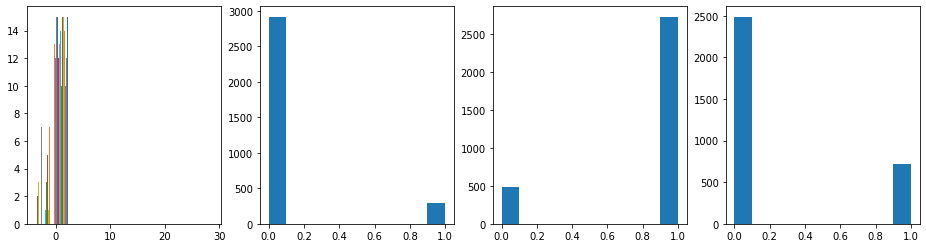

In [216]:
bins=10
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
axs[0].hist(X, bins=bins)
axs[1].hist(t, bins=bins)
axs[2].hist(y, bins=bins)
axs[3].hist(e, bins=bins)
plt.show()

In [217]:
x_train, x_test, t_train, t_test, y_train, y_test, e_train, e_test = train_test_split(X, t, y, e, test_size=0.2)

In [220]:
from sklearn.linear_model import LinearRegression
lg = LinearRegression()
dtr = DecisionTreeRegressor()

In [224]:
lg.fit(x_train, e_train)
print(lg.score(x_test, e_test))

0.6331480864021082


In [225]:
dtr.fit(x_train, y_train)
print(dtr.score(x_test, y_test))

-0.311276756084677


In [226]:
dtr.fit(x_train, t_train)
print(dtr.score(x_test, t_test))

-0.2898375331564984


In [ ]:
def get_weights(lg, x, t):
    ti = np.squeeze(t)
    lg.fit(x, ti)
    ptx = lg.predict(x).T[1].T + 0.001 # add a small value to avoid dividing by 0
    # Given ti and ptx values, compute the weights wi (see formula above):
    a= ti/ptx
    b= ((1-ti)/(1-ptx)) 

    wi = a+b
    return wi


weight1 = get_weights(lg, x_train, e_train)

In [227]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier()

In [228]:
dtc.fit(x_train, y_train)
print(dtr.score(x_test, y_test))

-5.755260938609642


In [229]:
#Predicting y with respect to x_test

y_pred = dtc.predict(x_test)

In [230]:
from sklearn import metrics
metrics.accuracy_score(y_test, y_pred)

In [231]:
dtc.fit(x_train, t_train)
print(dtr.score(x_test, t_test))

-0.2898375331564984


In [233]:
t_pred = dtc.predict(x_test)
metrics.accuracy_score(t_test, t_pred)

In [234]:
dtc.fit(x_train, e_train)
print(dtr.score(x_test, e_test))

-0.006977402556187062


In [235]:
e_pred = dtc.predict(x_test)

In [236]:
def get_ps_weights(clf, x, t):
    ti = np.squeeze(t)
    clf.fit(x, ti)
    ptx = clf.predict_proba(x).T[1].T + 0.0001 # add a small value to avoid dividing by 0
    # Given ti and ptx values, compute the weights wi (see formula above):
    a= ti/ptx
    b= ((1-ti)/(1-ptx)) 

    wi = a+b # YOUR CODE HERE
    return wi

weights = get_ps_weights(prop_clf, x_train, t_train)

dtr.fit(x_train, t_train, sample_weight= weights)
t_pred = dtc.predict(x_test)


# Compute ITEs
t_ipsw_test =  t_test - t_pred# YOUR CODE HERE
print(t_ipsw_test.mean())

-0.11975116640746501


# Model Evaluation

In [237]:
#Confusion matrix

from sklearn.metrics import confusion_matrix
confusion_matrix(e_test, e_pred)

array([[479,  27],
       [ 29, 108]])

In [238]:
#classification report for finding precision, recall, f1-score, support

from sklearn.metrics import classification_report
print(classification_report(e_test, e_pred))

              precision    recall  f1-score   support

         0.0       0.94      0.95      0.94       506
         1.0       0.80      0.79      0.79       137

    accuracy                           0.91       643
   macro avg       0.87      0.87      0.87       643
weighted avg       0.91      0.91      0.91       643



In [239]:
# X-Learner
xl = XLearner(models=RandomForestRegressor(), propensity_model=RandomForestClassifier())
xl.fit(y_train, t_train, X=x_train)

xl_te_test = xl.effect(x_test)

print(xl_te_test.mean())

-0.04301326578345489


Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
